<a href="https://colab.research.google.com/github/Muntasir2179/BERT-multiclass-emotion-classifier/blob/main/BERT_multiclass_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers

## Importing libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

## Importing dataset

In [6]:
df = pd.read_csv('Emotion Dataset (English Text).csv', index_col=0)

In [7]:
df.head()

,text,label
serial,,
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [9]:
df['label'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

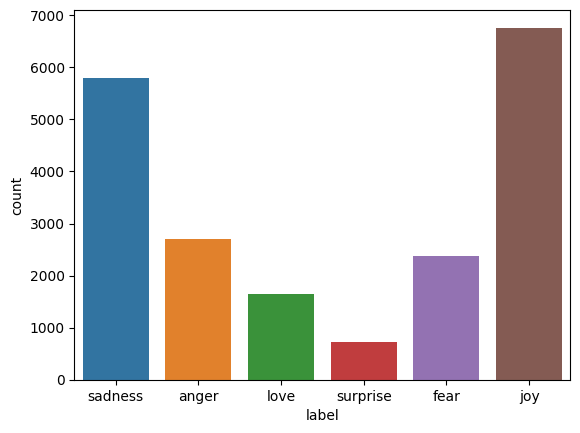

In [10]:
sns.countplot(x='label', data=df)

## Data preparation

In [11]:
# initializing the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7d2106a5-a424-4383-8258-fae0fabb46c2)')' thrown while requesting HEAD https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json


In [12]:
token = tokenizer.encode_plus(
    df['text'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
# special tokens refers to [CLS], [SEP], [PAD] tokens

In [13]:
x_input_ids = np.zeros((len(df), 256))
x_attn_masks = np.zeros((len(df), 256))

In [14]:
x_input_ids.shape

(20000, 256)

In [15]:
def generate_training_data(df, ids, masks, tokenizer):
  for i, text in tqdm(enumerate(df['text'])):
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    ids[i, :] = tokenized_text.input_ids  # populate all the ids for the i'th text
    masks[i, :] = tokenized_text.attention_mask  # populate all the masks for the i'th text
  return ids, masks

In [16]:
x_input_ids, x_attn_masks = generate_training_data(df, x_input_ids, x_attn_masks, tokenizer)

0it [00:00, ?it/s]

## Applying OneHot encodeing on the labels

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
labels = encoder.fit_transform((df['label'].to_numpy()).reshape(-1,1))

In [18]:
import pickle
with open("onehot_encoder_for_BERT_multiclass_classification.pkl", "wb") as f:
    pickle.dump(encoder, f)

In [19]:
labels = labels.toarray()

In [20]:
labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

## Creating data slices

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((x_input_ids, x_attn_masks, labels))

In [22]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [23]:
# map function
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }, labels

In [24]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [25]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [26]:
dataset = dataset.shuffle(20000).batch(16, drop_remainder=True)

In [27]:
len(dataset)

1250

In [28]:
train_size = int((len(dataset)) * 0.8)

In [29]:
train_size

1000

In [30]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [31]:
len(train_dataset)

1000

In [32]:
len(val_dataset)

250

## Model creation

In [33]:
from transformers import TFBertModel

In [34]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [35]:
# input layers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

In [36]:
bert_embds = bert_model.bert(input_ids, attention_mask=attention_masks)[1]
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='output_layer')(intermediate_layer)

In [37]:
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [38]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=1e-6)
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [39]:
model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [40]:
hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 5
)

Epoch 1/5
1000/1000 [==============================] - 923s 869ms/step - loss: 0.6916 - accuracy: 0.7961 - val_loss: 0.3020 - val_accuracy: 0.9293
Epoch 2/5
1000/1000 [==============================] - 867s 867ms/step - loss: 0.3299 - accuracy: 0.9207 - val_loss: 0.2752 - val_accuracy: 0.9323
Epoch 3/5
1000/1000 [==============================] - 864s 864ms/step - loss: 0.2935 - accuracy: 0.9301 - val_loss: 0.2615 - val_accuracy: 0.9365
Epoch 4/5
1000/1000 [==============================] - 864s 863ms/step - loss: 0.2914 - accuracy: 0.9293 - val_loss: 0.2628 - val_accuracy: 0.9377
Epoch 5/5
1000/1000 [==============================] - 864s 863ms/step - loss: 0.2849 - accuracy: 0.9339 - val_loss: 0.2457 - val_accuracy: 0.9430


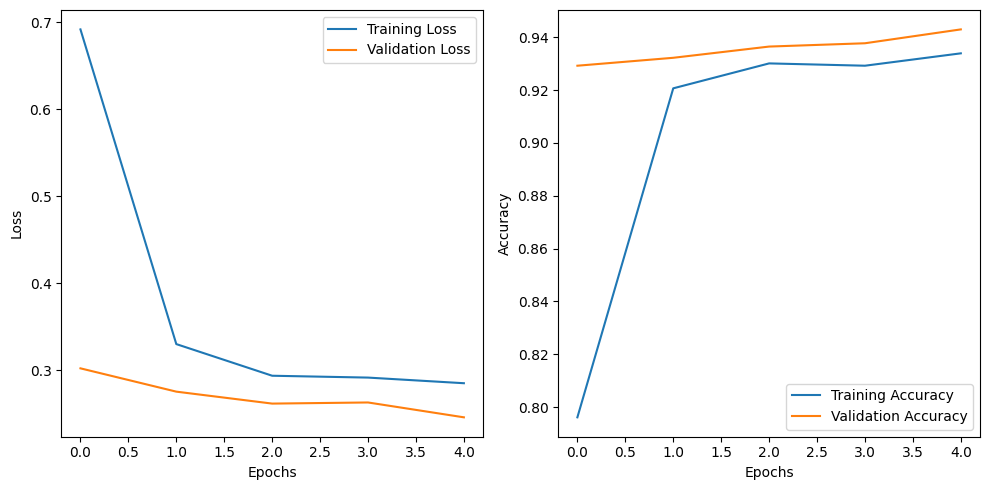

In [41]:
# Extract training and validation metrics from history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Saving the trained model

In [42]:
model.save('/content/drive/MyDrive/Trained Models/bert_sentiment_classifier')

## Loading the trained model

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.0 MB/s eta 0:00:00


In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer
import pickle

In [44]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Trained Models/bert_sentiment_classifier')

In [45]:
with open('/content/drive/MyDrive/Trained Models/onehot_encoder_for_BERT_multiclass_classification.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [46]:
def get_prediction(input_text):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  # creating input ids and attention_masks of the input text
  token = tokenizer.encode_plus(
      input_text,
      max_length=256,
      truncation=True,
      padding='max_length',
      add_special_tokens=True,
      return_tensors='tf'
  )

  tokenized_input_text = {
      'input_ids': tf.cast(token.input_ids, tf.float64),
      'attention_mask': tf.cast(token.attention_mask, tf.float64)
  }

  # will give us the probability distributions of each output class
  prediction_probabilities = loaded_model.predict(tokenized_input_text)
  label = np.zeros(6)
  label[np.argmax(prediction_probabilities[0])] = 1.0
  label = encoder.inverse_transform(label.reshape(1, -1))
  return label

In [47]:
print(get_prediction(input())[0][0])

I am feeling very happy.
1/1 [==============================] - 3s 3s/step
joy


## Divide datset into 5 parts and generating prediction

In [48]:
dataset = pd.read_csv('Emotion Dataset (English Text).csv', index_col=0)

In [49]:
data_1 = dataset.iloc[:100, :]
data_2 = dataset.iloc[100:200, :]
data_3 = dataset.iloc[200:300, :]
data_4 = dataset.iloc[300:400, :]
data_5 = dataset.iloc[400:500, :]

print(data_1.shape)
print(data_2.shape)
print(data_3.shape)
print(data_4.shape)
print(data_5.shape)

(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)


In [50]:
# generating predictions for data_1
predictions = []
for text in data_1['text']:
  predictions.append(get_prediction(text)[0][0])

1/1 [==============================] - 0s 75ms/step


In [51]:
predictions = pd.DataFrame(predictions, columns=['predictions'])
data_1 = pd.concat([data_1, predictions], axis=1)
data_1.head()

,text,label,predictions
0,i didnt feel humiliated,sadness,sadness
1,i can go from feeling so hopeless to so damned...,sadness,sadness
2,im grabbing a minute to post i feel greedy wrong,anger,anger
3,i am ever feeling nostalgic about the fireplac...,love,love
4,i am feeling grouchy,anger,anger


In [52]:
match_count = 0
non_match_count = 0

for label, predictions in zip(data_1['label'], data_1['predictions']):
  if label!=predictions:
    non_match_count += 1
  else:
    match_count += 1

In [53]:
print('Correct predictions: {}'.format(match_count))
print('Incorrect predictions: {}'.format(non_match_count))
print('The accuracy: {}'.format(match_count/len(data_1)))

Correct predictions: 98
Incorrect predictions: 2
The accuracy: 0.98


## Evaluation parameters

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score

In [55]:
y_test = data_1['label']
y_pred = data_1['predictions']
classes = dataset['label'].unique()

In [56]:
print('Test set performance for model')
print('Accuracy score : ', accuracy_score(y_test, y_pred))
print('F1 score       : ', f1_score(y_test, y_pred, average='weighted'))
print('Precision score: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall score   : ', recall_score(y_test, y_pred, average='weighted'))

Test set performance for model
Accuracy score :  0.98
F1 score       :  0.9809558823529412
Precision score:  0.9844444444444445
Recall score   :  0.98


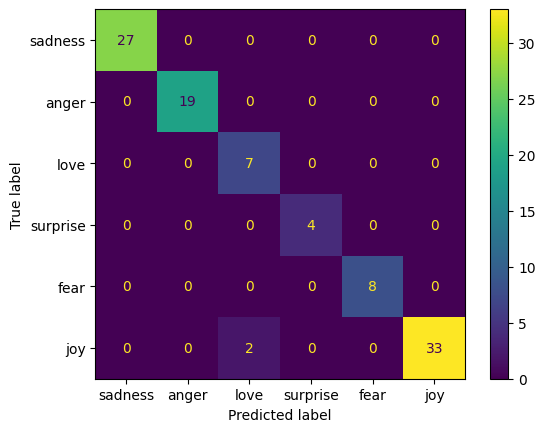

In [57]:
# setting confusion matrix parameters
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# showing confusion matrix
disp.plot()
plt.show()